In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import neural
import copy
import functions
import pickle
import os

import enum

# Define Stuff

## Neural Networks

In [165]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def can_compute_g_factor(self):
        return False

    def compute_g_factor(self):
        return None

    def forward(self, x):
        pass

    def copy_profile_weights(self, other_model):
        self.load_state_dict(other_model.state_dict(), strict=False)


class NeuralNetworkDirect(NeuralNetwork):
    """
        Basic Neural Network
    """
    def __init__(self, layers, activation_function=torch.tanh):
        """
            Initializes the neural network with the layers and activation fuction
            selected.

            # Arguments
            - layers: is given as an array of integers which correspond to the width of
                each layer.
            
            - activation_function: a function that goes from R to R.
        """
        super().__init__()
        self.Ws = torch.nn.ParameterList()
        self.bs = torch.nn.ParameterList()
        self.n_layers = len(layers)-1
        self.sigma = activation_function
        
        for i in range(self.n_layers):
            in_size = layers[i]
            out_size = layers[i+1]
            std_dev = np.sqrt(2/(in_size + out_size))
            W = torch.normal(
                0, std_dev,
                (out_size, in_size),
                requires_grad=True
            )
            b = torch.normal(
                0,
                std_dev,
                (out_size, 1),
                requires_grad=True
            )
            
            self.Ws.append(W)
            self.bs.append(b)
    

    def forward(self, x):
        """Compute the output of the neural network for an input x"""

        for i in range(self.n_layers-1):
            x = self.sigma(self.Ws[i] @ x + self.bs[i])
        
        return self.Ws[self.n_layers-1] @ x + self.bs[self.n_layers-1]
    


class NeuralNetworkGInference(NeuralNetworkDirect):
    """
        Basic Neural Network
    """
    def __init__(self, layers, g_layers, activation_function=torch.tanh, g_activation_function=torch.relu):
        """
            Initializes the neural network with the layers and activation fuction
            selected.

            # Arguments
            - layers: is given as an array of integers which correspond to the width of
                each layer.
            
            - activation_function: a function that goes from R to R.
        """
        super().__init__(layers, activation_function)

        self.Ws_g = torch.nn.ParameterList()
        self.bs_g = torch.nn.ParameterList()
            
        self.n_g_layers = len(g_layers)-1
        self.g_sigma = g_activation_function

        for i in range(self.n_g_layers):
            in_size = g_layers[i]
            out_size = g_layers[i+1]
            std_dev = np.sqrt(2/(in_size + out_size))
            W = torch.normal(
                0, std_dev,
                (out_size, in_size),
                requires_grad=True
            )
            b = torch.normal(
                0,
                std_dev,
                (out_size, 1),
                requires_grad=True
            )
            
            self.Ws_g.append(W)
            self.bs_g.append(b)

    

    def can_compute_g_factor(self):
        return True


    def compute_g_factor(self, x):
        """Compute the output of the nueral network for an input x"""
        
        for i in range(self.n_g_layers-1):
            x = self.g_sigma(self.Ws_g[i] @ x + self.bs_g[i])
        
        return torch.exp(self.Ws_g[self.n_g_layers-1] @ x + self.bs_g[self.n_g_layers-1])



class NeuralNetworkGKernel(NeuralNetworkDirect):
    """
        Basic Neural Network
    """
    def __init__(self, layers, n_faults, initial_sigma, activation_function=torch.tanh):
        """
            Initializes the neural network with the layers and activation fuction
            selected.

            # Arguments
            - layers: is given as an array of integers which correspond to the width of
                each layer.
            
            - activation_function: a function that goes from R to R.
        """
        super().__init__(layers, activation_function)

        self.means = torch.nn.Parameter(torch.ones(n_faults, requires_grad=True) * 0.5)
        self.log_values = torch.nn.Parameter(torch.zeros(n_faults, requires_grad=True))
        self.g_sigma = initial_sigma
        self.g_sigma.requires_grad_(True)
        self.n_faults = n_faults


    

    def can_compute_g_factor(self):
        return True


    def compute_g_factor(self, x):
        """Compute the output of the nueral network for an input x"""
        out = torch.zeros(1, x.shape[1])
        for i in range(self.n_faults):
            out = out + self.log_values[i] * torch.exp(-torch.square(x - self.means[i])/self.g_sigma**2)

        return torch.exp(out)
        
        
    def set_sigma(self, new_sigma):
        self.g_sigma = new_sigma
        self.g_sigma.requires_grad_(True)

## Plotting Functions

In [166]:
class Representer:

    @staticmethod
    def compare(
        simulation_data: functions.TransmissionLineSimulation,
        model: NeuralNetwork,
        x_array=None,
        t_array=None,
        physics_runner=None
    ):


        if x_array is None:
            x_array = simulation_data.x_array

        if t_array is None:
            t_array = simulation_data.t_array

        interpolate_measurements = (t_array is not None) or (x_array is not None)

        X, T = np.meshgrid(x_array, t_array)

        if interpolate_measurements:
            simulation_v = simulation_data.sample(x_array, t_array, mode="voltage")[1].reshape(X.shape)
            simulation_i = simulation_data.sample(x_array, t_array, mode="current")[1].reshape(X.shape)
        else:
            simulation_v = simulation_data.v_grid.T
            simulation_i = simulation_data.i_grid.T

        with torch.no_grad():
            input = torch.stack(
                (
                    torch.tensor(X, dtype=torch.float).reshape(-1),
                    torch.tensor(T, dtype=torch.float).reshape(-1)
                )
            )
            model_output = np.array(model(input))
        
        model_v = model_output[0, :].reshape(X.shape)
        model_i = model_output[1, :].reshape(X.shape)

        fig, axes = plt.subplots(2, 4)

        axes[0, 0].pcolormesh(X, T, simulation_v, cmap="coolwarm")
        axes[1, 0].pcolormesh(X, T, simulation_i, cmap="coolwarm")

        axes[0, 1].pcolormesh(X, T, model_v, cmap="coolwarm")
        axes[1, 1].pcolormesh(X, T, model_i, cmap="coolwarm")

        axes[0, 2].pcolormesh(X, T, np.square(model_v - simulation_v))
        axes[1, 2].pcolormesh(X, T, np.square(model_i - simulation_i))

        if physics_runner is not None:
            physics_runner = copy.copy(physics_runner)
            physics_runner.change_input(input)
            physics_loss = physics_runner.compute_point_loss(model).detach().numpy()
            axes[0, 3].pcolormesh(X, T, physics_loss.reshape(X.shape))

            pass

        axes[0, 0].set(title="Simulation", ylabel="Voltage")
        axes[0, 1].set(title="Model")
        axes[1, 0].set(ylabel="Current")

        axes[0, 2].set_title("Error")
        axes[0, 3].set_title("Physics error")

## Loss Methods

In [167]:
class MeasurementType(enum.Enum):
    Voltage = 1,
    Current = 2


class Loss:
    def compute_point_loss(self, model) -> torch.Tensor :
        pass

    def compute_loss(self, model) -> torch.Tensor :
        return self.compute_point_loss(model).mean()


class MeasurementLoss(Loss):
    def __init__(self, simulation_data: functions.TransmissionLineSimulation, x_array, t_array, measurement_type: MeasurementType):
        if measurement_type == MeasurementType.Voltage:
            measurement_name = "voltage"
        else:
            measurement_name = "current"

        x, y = simulation_data.sample(x_array, t_array, measurement_name)
        self.x = torch.tensor(x, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float)
        self.measurement_type = measurement_type

    def compute_point_loss(self, model):
        model_output = model(self.x)

        if self.measurement_type == MeasurementType.Voltage:
            output = model_output[0, :]
        else:
            output = model_output[1, :]


        return torch.square(self.y - output)


class PhysicsLoss(Loss):
    def __init__(self, simulation_data: functions.TransmissionLineSimulation, input: torch.Tensor):
        self.G = simulation_data.parameters.Go
        self.R = simulation_data.parameters.Ro
        self.C = simulation_data.parameters.Co
        self.L = simulation_data.parameters.Lo

        self.input = input
        self.input.requires_grad_(True)


    def change_input(self, new_input: torch.Tensor):
        self.input = new_input
        self.input.requires_grad_(True)

    def compute_point_loss(self, model: NeuralNetwork):
        output = model(self.input)

        if model.can_compute_g_factor():
            g_factor = model.compute_g_factor(self.input[0:1, :])
        else:
            g_factor = torch.ones(self.input.shape[1])

        v = output[0, :]
        i = output[1, :]

        grad_v = torch.autograd.grad(v, self.input, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        grad_i = torch.autograd.grad(i, self.input, grad_outputs=torch.ones_like(i), retain_graph=True, create_graph=True)[0]

        v_x = grad_v[0, :]
        v_t = grad_v[1, :]
        i_x = grad_i[0, :]
        i_t = grad_i[1, :]

        eq_1_error = v_x + self.L * i_t + self.R * i # + gamma * i_xx
        eq_2_error = i_x + self.C * v_t + self.G * g_factor * v # + gamma * v_xx
        
        return torch.square(eq_1_error) + torch.square(eq_2_error)


class ICLoss(Loss):
    def __init__(self, n_x):
        x_array = torch.linspace(0, 1, n_x)
        self.input = torch.stack((x_array, torch.zeros(n_x)))

    def compute_point_loss(self, model):
        return torch.sum(torch.square(model(self.input)), 0)


class GLoss(Loss):
    def __init__(self, n_x, function):
        self.input = torch.linspace(0, 1, n_x).reshape(1, -1)
        self.function = function

    def compute_point_loss(self, model):
        return self.function(model.compute_g_factor(self.input))

class GBorderLoss(Loss):
    def __init__(self):
        self.input = torch.tensor([0., 1.]).reshape(1, -1)

    def compute_point_loss(self, model):
        return model.compute_g_factor(self.input).log().square().mean()

# Train Direct Method

In [184]:
model = NeuralNetworkDirect([2, 10, 10, 10, 2])

simulation_data = functions.TransmissionLineSimulation.load("data/case_a.pt")

voltage_runner = MeasurementLoss(simulation_data, [0, 1], np.linspace(0, 1, 200), MeasurementType.Voltage)
current_runner = MeasurementLoss(simulation_data, [0, 1], np.linspace(0, 1, 200), MeasurementType.Current)
physics_runner = PhysicsLoss(simulation_data, torch.rand((2, 2000)))
ic_runner = ICLoss(200)

n_epochs = 15000
loss_array = np.zeros((n_epochs, 5))

optimizer = torch.optim.Adam(model.parameters())

for i in range(n_epochs):

    optimizer.zero_grad()

    voltage_loss = voltage_runner.compute_loss(model)
    current_loss = current_runner.compute_loss(model)
    physics_loss = physics_runner.compute_loss(model)
    ic_loss = ic_runner.compute_loss(model)

    loss = (voltage_loss + current_loss + physics_loss + ic_loss)/4

    loss_array[i, :] = [
        loss.detach().numpy(),
        voltage_loss.detach().numpy(),
        current_loss.detach().numpy(),
        physics_loss.detach().numpy(),
        ic_loss.detach().numpy()
    ]
        

    if (i % 1000) == 0:
        print(loss)

    loss.backward()

    optimizer.step()


correct_model = model

tensor(0.7857, grad_fn=<DivBackward0>)
tensor(0.0724, grad_fn=<DivBackward0>)
tensor(0.0286, grad_fn=<DivBackward0>)
tensor(0.0188, grad_fn=<DivBackward0>)
tensor(0.0055, grad_fn=<DivBackward0>)
tensor(0.0019, grad_fn=<DivBackward0>)
tensor(0.0014, grad_fn=<DivBackward0>)
tensor(0.0008, grad_fn=<DivBackward0>)
tensor(0.0003, grad_fn=<DivBackward0>)
tensor(0.0002, grad_fn=<DivBackward0>)
tensor(0.0002, grad_fn=<DivBackward0>)
tensor(0.0001, grad_fn=<DivBackward0>)
tensor(0.0001, grad_fn=<DivBackward0>)
tensor(0.0001, grad_fn=<DivBackward0>)
tensor(9.4209e-05, grad_fn=<DivBackward0>)


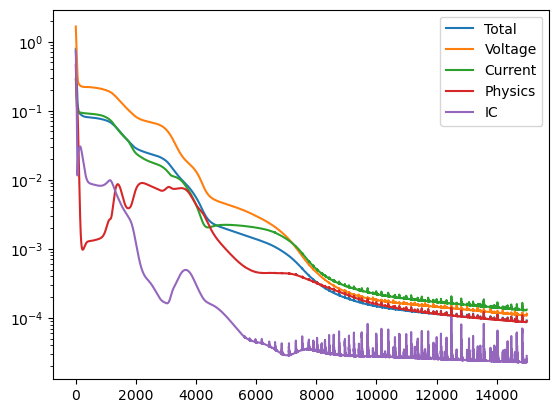

In [185]:
epochs = np.arange(0, n_epochs)
fig, ax = plt.subplots()
ax.semilogy(epochs, loss_array)
ax.legend(
    ["Total", "Voltage", "Current", "Physics", "IC"]
)

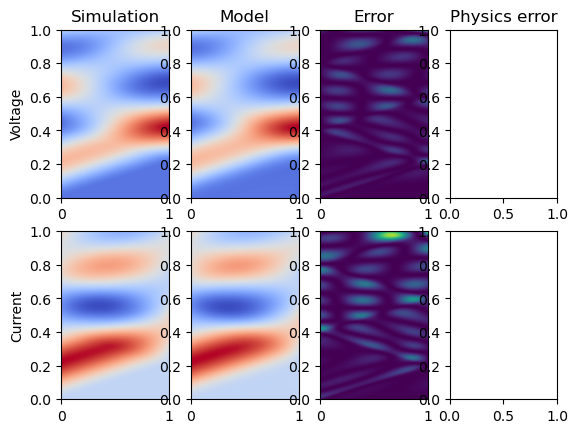

In [182]:
Representer.compare(simulation_data, model)

# Direct with Adaptive Weights

In [186]:
model = NeuralNetworkDirect([2, 10, 10, 10, 2])
n_epochs = 15000

simulation_data = functions.TransmissionLineSimulation.load("data/case_a.pt")

voltage_runner = MeasurementLoss(simulation_data, [0, 1], np.linspace(0, 1, 200), MeasurementType.Voltage)
current_runner = MeasurementLoss(simulation_data, [0, 1], np.linspace(0, 1, 200), MeasurementType.Current)
physics_runner = PhysicsLoss(simulation_data, torch.rand((2, 2000)))
ic_runner = ICLoss(200)

loss_array = np.zeros((n_epochs, 5))

lambdas = torch.ones(4, requires_grad=True)


optimizer = torch.optim.Adam(model.parameters())
lambda_optimizer = torch.optim.Adam([lambdas], maximize=True)

for i in range(n_epochs):

    optimizer.zero_grad()
    lambda_optimizer.zero_grad()

    voltage_loss = voltage_runner.compute_loss(model)
    current_loss = current_runner.compute_loss(model)
    physics_loss = physics_runner.compute_loss(model)
    ic_loss = ic_runner.compute_loss(model)



    loss = lambdas[0] * voltage_loss \
        + lambdas[1] * current_loss + \
        + lambdas[2] * physics_loss + \
        + lambdas[3] * ic_loss

    loss = loss/torch.sum(lambdas)


    loss_array[i, :] = [
        loss.detach().numpy(),
        voltage_loss.detach().numpy(),
        current_loss.detach().numpy(),
        physics_loss.detach().numpy(),
        ic_loss.detach().numpy()
    ]
        

    if (i % 1000) == 0:
        print(loss)

    loss.backward()

    optimizer.step()
    lambda_optimizer.step()


correct_model = model
print(lambdas)

tensor(2.3966, grad_fn=<DivBackward0>)
tensor(0.0939, grad_fn=<DivBackward0>)
tensor(0.0639, grad_fn=<DivBackward0>)
tensor(0.0389, grad_fn=<DivBackward0>)
tensor(0.0266, grad_fn=<DivBackward0>)
tensor(0.0175, grad_fn=<DivBackward0>)
tensor(0.0021, grad_fn=<DivBackward0>)
tensor(0.0009, grad_fn=<DivBackward0>)
tensor(0.0006, grad_fn=<DivBackward0>)
tensor(0.0004, grad_fn=<DivBackward0>)
tensor(0.0002, grad_fn=<DivBackward0>)
tensor(0.0001, grad_fn=<DivBackward0>)
tensor(7.9887e-05, grad_fn=<DivBackward0>)
tensor(6.7947e-05, grad_fn=<DivBackward0>)
tensor(6.0826e-05, grad_fn=<DivBackward0>)
tensor([1.4932, 1.0583, 0.9613, 0.0501], requires_grad=True)


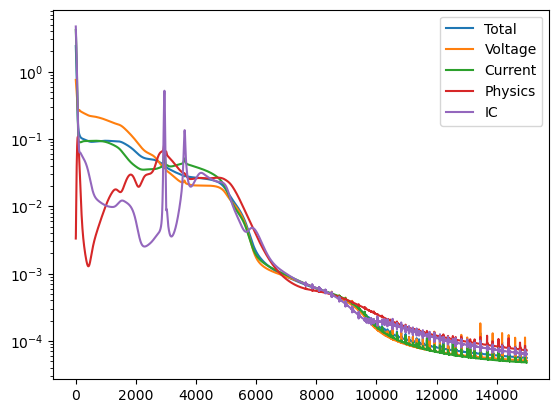

In [187]:
epochs = np.arange(0, n_epochs)
fig, ax = plt.subplots()
ax.semilogy(epochs, loss_array)
ax.legend(
    ["Total", "Voltage", "Current", "Physics", "IC"]
)

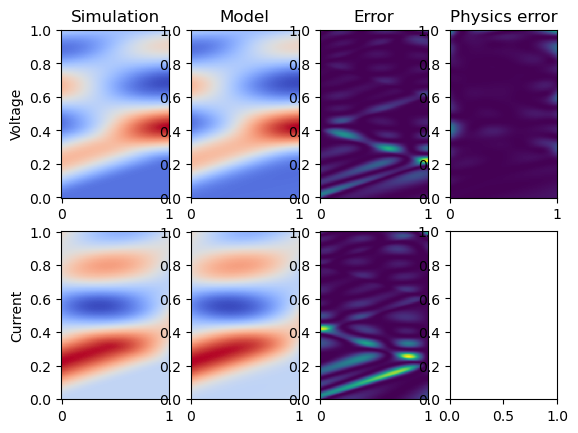

In [180]:
x_plot = np.linspace(0, 1, 300)
t_plot = np.linspace(0, 1, 300)
Representer.compare(simulation_data, model, physics_runner=physics_runner, x_array=x_plot, t_array=t_plot)

# Train Indirect Method

In [170]:
final_profiles = np.zeros((5, 500))


for experiment in range(5):
    model = NeuralNetworkGInference([2, 10, 10, 10, 2], [1, 10, 10, 10, 1])

    model.copy_profile_weights(correct_model)

    simulation_data = functions.TransmissionLineSimulation.load("data/case_b.pt")

    voltage_runner = MeasurementLoss(simulation_data, [0, 1], np.linspace(0, 1, 200), MeasurementType.Voltage)
    current_runner = MeasurementLoss(simulation_data, [0, 1], np.linspace(0, 1, 200), MeasurementType.Current)
    physics_runner = PhysicsLoss(simulation_data, torch.rand((2, 2000)))
    ic_runner = ICLoss(200)
    g_runner = GLoss(300, lambda x: torch.abs(torch.log(x)))
    g_border_runner = GBorderLoss()
    # g_runner = GLoss(300, lambda x: torch.log(1 + 2*torch.square(torch.log(x))))

    n_epochs = 15000

    optimizer = torch.optim.Adam(model.parameters())

    loss_array = np.zeros((n_epochs, 5))

    for i in range(n_epochs):

        optimizer.zero_grad()

        voltage_loss = voltage_runner.compute_loss(model)
        current_loss = current_runner.compute_loss(model)
        physics_loss = physics_runner.compute_loss(model)
        ic_loss = ic_runner.compute_loss(model)
        g_loss = g_runner.compute_loss(model)
        g_border_loss = g_border_runner.compute_loss(model)

        loss = voltage_loss + current_loss + physics_loss + ic_loss + 0*0.01*g_loss + g_border_loss

        loss_array[i, :] = [
            loss.detach().numpy(),
            voltage_loss.detach().numpy(),
            current_loss.detach().numpy(),
            physics_loss.detach().numpy(),
            ic_loss.detach().numpy()
        ]
            

        if (i % 1000) == 0:
            print(loss)

        loss.backward()

        optimizer.step()


    final_profiles[experiment, :] = model.compute_g_factor(torch.linspace(0, 1, 500).reshape(1, -1)).reshape(-1).detach().numpy()

tensor(1.1458, grad_fn=<AddBackward0>)
tensor(0.1834, grad_fn=<AddBackward0>)
tensor(0.0668, grad_fn=<AddBackward0>)
tensor(0.0356, grad_fn=<AddBackward0>)
tensor(0.0240, grad_fn=<AddBackward0>)
tensor(0.0175, grad_fn=<AddBackward0>)
tensor(0.0125, grad_fn=<AddBackward0>)
tensor(0.0102, grad_fn=<AddBackward0>)
tensor(0.0089, grad_fn=<AddBackward0>)
tensor(0.0080, grad_fn=<AddBackward0>)
tensor(0.0072, grad_fn=<AddBackward0>)
tensor(0.0067, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<AddBackward0>)
tensor(0.0059, grad_fn=<AddBackward0>)
tensor(0.0056, grad_fn=<AddBackward0>)
tensor(1.4604, grad_fn=<AddBackward0>)
tensor(0.2665, grad_fn=<AddBackward0>)
tensor(0.0896, grad_fn=<AddBackward0>)
tensor(0.0401, grad_fn=<AddBackward0>)
tensor(0.0264, grad_fn=<AddBackward0>)
tensor(0.0196, grad_fn=<AddBackward0>)
tensor(0.0149, grad_fn=<AddBackward0>)
tensor(0.0132, grad_fn=<AddBackward0>)
tensor(0.0111, grad_fn=<AddBackward0>)
tensor(0.0100, grad_fn=<AddBackward0>)
tensor(0.0087, grad_fn=<A

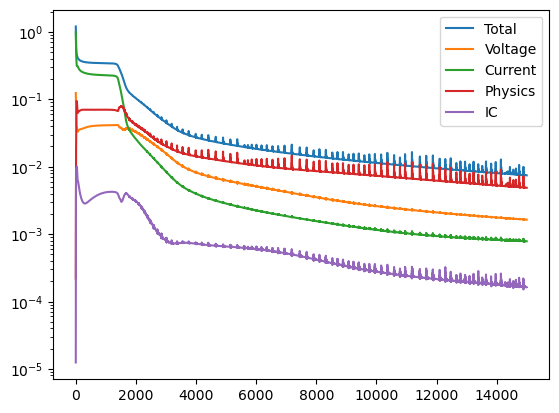

In [162]:
epochs = np.arange(0, n_epochs)
fig, ax = plt.subplots()
ax.semilogy(epochs, loss_array)
ax.legend(
    ["Total", "Voltage", "Current", "Physics", "IC"]
)

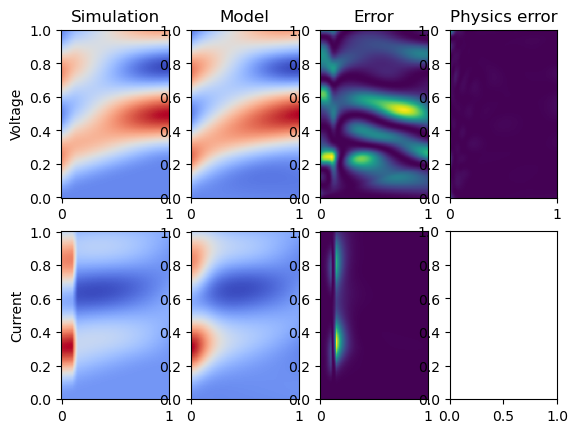

In [163]:
x_plot = np.linspace(0, 1, 300)
t_plot = np.linspace(0, 1, 300)
Representer.compare(simulation_data, model, physics_runner=physics_runner, x_array=x_plot, t_array=t_plot)

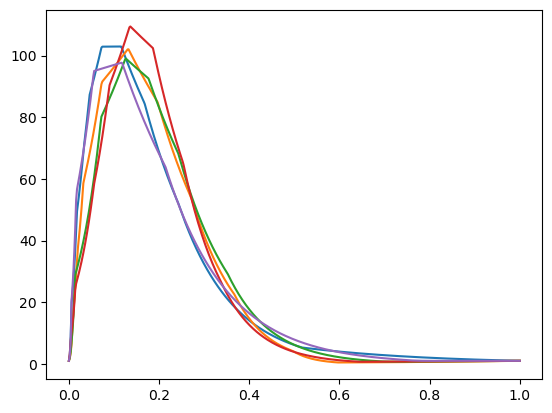

In [171]:
fig, ax = plt.subplots()
ax.plot(
    torch.linspace(0, 1, 500),
    final_profiles.T
)

/tmp/ipykernel_3321/3301273638.py:3: RuntimeWarning: divide by zero encountered in log
  ax.plot(g_factor, np.log(1 + 2*np.square(np.log(g_factor))))


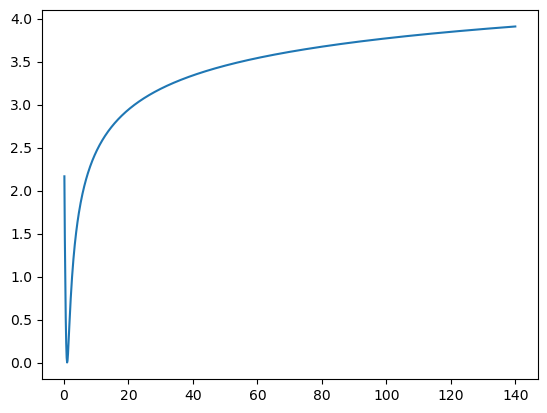

In [126]:
g_factor = np.linspace(0, 140, 1000)
fig, ax = plt.subplots()
ax.plot(g_factor, np.log(1 + 2*np.square(np.log(g_factor))))

# Forcing Sigmas

In [26]:
all_traj = np.zeros((10, 15000))

for run_index in range(10):

    initial_sigma = torch.tensor(1)
    final_sigma = torch.tensor(0.02)

    # measure_points = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    measure_points = [0, 1]

    model = NeuralNetworkGKernel([2, 10, 10, 10, 2], 1, torch.tensor(1.))
    model.copy_profile_weights(correct_model)

    simulation_data = functions.TransmissionLineSimulation.load("data/case_b.pt")

    voltage_runner = MeasurementLoss(simulation_data, measure_points, np.linspace(0, 1, 200), MeasurementType.Voltage)
    current_runner = MeasurementLoss(simulation_data, measure_points, np.linspace(0, 1, 200), MeasurementType.Current)
    physics_runner = PhysicsLoss(simulation_data, torch.rand((2, 2000)))
    ic_runner = ICLoss(200)

    n_epochs = 15000

    optimizer = torch.optim.Adam(model.parameters())

    loss_array = np.zeros((n_epochs, 5))
    mean_array = np.zeros(n_epochs)

    updating_alpha = True
    min_loss = 1000

    for i in range(n_epochs):
        if updating_alpha:
            alpha = i/n_epochs

        sigma = torch.exp((1-alpha) * torch.log(initial_sigma) + alpha * torch.log(final_sigma))
        model.set_sigma(sigma)

        optimizer.zero_grad()

        voltage_loss = voltage_runner.compute_loss(model)
        current_loss = current_runner.compute_loss(model)
        physics_loss = physics_runner.compute_loss(model)
        ic_loss = ic_runner.compute_loss(model)

        loss = voltage_loss + current_loss + physics_loss + ic_loss

        loss_array[i, :] = [
            loss.detach().numpy(),
            voltage_loss.detach().numpy(),
            current_loss.detach().numpy(),
            physics_loss.detach().numpy(),
            ic_loss.detach().numpy()
        ]
            

        if (i % 1000) == 0:
            print(loss)
            if loss.detach().numpy() < min_loss:
                min_loss = loss.detach().numpy()
                updating_alpha = True
            else:
                updating_alpha = False

        mean_array[i] = model.means[0].detach().numpy()
        all_traj[run_index, i] = model.means[0].detach().numpy()

        loss.backward()

        optimizer.step()


tensor(1.0277, grad_fn=<AddBackward0>)
tensor(0.2633, grad_fn=<AddBackward0>)
tensor(0.1594, grad_fn=<AddBackward0>)
tensor(0.0519, grad_fn=<AddBackward0>)
tensor(0.0224, grad_fn=<AddBackward0>)
tensor(0.0173, grad_fn=<AddBackward0>)
tensor(0.0187, grad_fn=<AddBackward0>)
tensor(0.0118, grad_fn=<AddBackward0>)
tensor(0.0634, grad_fn=<AddBackward0>)
tensor(0.0371, grad_fn=<AddBackward0>)
tensor(0.0300, grad_fn=<AddBackward0>)
tensor(0.0266, grad_fn=<AddBackward0>)
tensor(0.0239, grad_fn=<AddBackward0>)
tensor(0.0226, grad_fn=<AddBackward0>)
tensor(0.0198, grad_fn=<AddBackward0>)
tensor(1.0277, grad_fn=<AddBackward0>)
tensor(0.2631, grad_fn=<AddBackward0>)
tensor(0.1596, grad_fn=<AddBackward0>)
tensor(0.0473, grad_fn=<AddBackward0>)
tensor(0.0175, grad_fn=<AddBackward0>)
tensor(0.0170, grad_fn=<AddBackward0>)
tensor(0.0242, grad_fn=<AddBackward0>)
tensor(0.0143, grad_fn=<AddBackward0>)
tensor(0.0460, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0248, grad_fn=<A

Parameter containing:
tensor([0.0933], requires_grad=True)
Parameter containing:
tensor([5.6756], requires_grad=True)


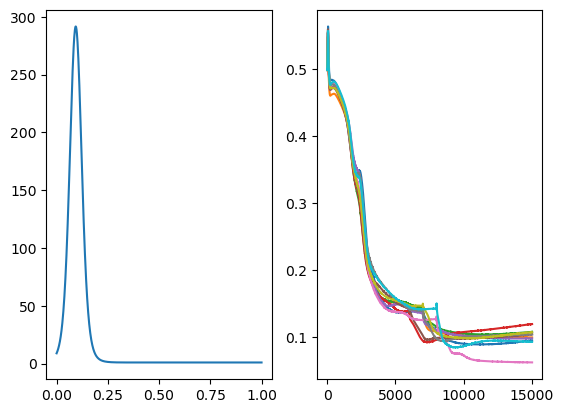

In [28]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(
    torch.linspace(0, 1, 1000),
    model.compute_g_factor(torch.linspace(0, 1, 1000).reshape(1,-1)).reshape(-1).detach()
)
axes[1].plot(all_traj.T)

print(model.means)
print(model.log_values)


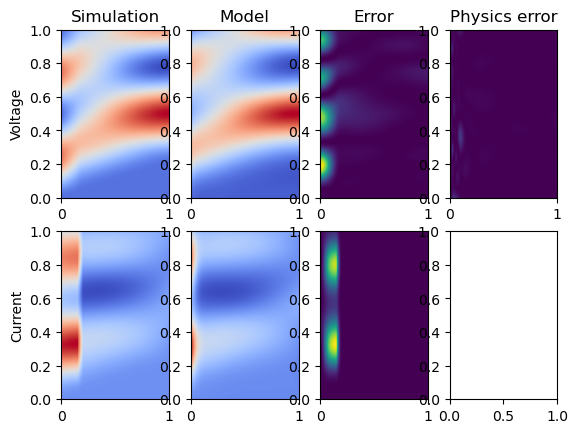

In [18]:
Representer.compare(simulation_data, model, physics_runner=physics_runner)